In [2]:
import os, time, shutil
from pathlib import Path
from glob import glob
import numpy as np
import spikeinterface.full as si
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
sorter = 'kilosort2_5'
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/phornauer/Git/Kilosort_2020b')
sorter_params = si.get_default_sorter_params(si.Kilosort2_5Sorter)
sorter_params['n_jobs'] = -1
sorter_params['detect_threshold'] = 5.5
sorter_params['minFR'] = 0.01
sorter_params['minfr_goodchannels'] = 0.01
sorter_params['keep_good_only'] = False
sorter_params['do_correction'] = False
print(sorter_params)

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/phornauer/Git/Kilosort_2020b
{'detect_threshold': 5.5, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.01, 'minfr_goodchannels': 0.01, 'nblocks': 5, 'sig': 20, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'do_correction': False, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': True, 'delete_recording_dat': False, 'n_jobs': -1, 'chunk_duration': '1s', 'progress_bar': True}


In [5]:
def clean_sorting(rec, save_root, stream_name):
    
    # Creates output folder, sorts and clears large temporary files
    save_path = os.path.join(save_root,stream_name)
    output_folder = Path(os.path.join(save_path, 'sorted'))
    
    if not os.path.exists(os.path.join(output_folder,'amplitudes.npy')):
        output_folder.mkdir(parents=True, exist_ok=True)
        raw_file = os.path.join(output_folder,'recording.dat')
        wh_file = os.path.join(output_folder, 'temp_wh.dat')
        
        print(f"DURATION: {rec.get_num_frames() / rec.get_sampling_frequency()} s -- "
                f"NUM. CHANNELS: {rec.get_num_channels()}")
        
        try:
            t_start_sort = time.time()
            sorting = si.run_sorter(sorter, rec, output_folder=output_folder, verbose=True,
                                    **sorter_params)
            print(f"\n\nSpike sorting elapsed time {time.time() - t_start_sort} s")
            
            #Making sure we clean up the temporary .npy files
            if os.path.exists(wh_file):
                os.remove(wh_file)
            if os.path.exists(raw_file):
                os.remove(raw_file)
        except Exception as e:
            sorting = []
            print(e)
            if os.path.exists(wh_file):
                os.remove(wh_file)
            if os.path.exists(raw_file):
                os.remove(raw_file)
                
    return sorting

In [6]:
file_path = "/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/nobenz/230427/How_old/M05562/AxonTracking/000004/"
file_name = "data.raw.h5"
full_path = os.path.join(file_path,file_name)
stream_name = "well001"

In [182]:
assert(os.path.exists(full_path))
rec_id = 0
common_el = list(range(30000))
while rec_id < 3: #True:
    rec_name = 'rec' + '%0*d' % (4, rec_id)
    try:
        rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)
        rec_el = rec.get_property("contact_vector")["electrode"]
        common_el = list(set(common_el).intersection(rec_el))
        rec_id += 1
    except Exception:
        break
            

In [490]:
rec_list = []
for r in range(rec_id): #rec_id
    rec_name = 'rec' + '%0*d' % (4, r)
    rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)
    ch_id = rec.get_property("contact_vector")['device_channel_indices']
    rec_el = rec.get_property("contact_vector")["electrode"]
    
    chan_idx = [np.where(rec_el == el)[0][0] for el in common_el[2:6]]
    print(f'x{rec.get_property("contact_vector")["x"][chan_idx]}y{rec.get_property("contact_vector")["y"][chan_idx]}')
    sel_channels = rec.get_channel_ids()[chan_idx]
    rec_centered = si.filter(rec, band=[150,4999])
    rec_list.append(rec_centered.channel_slice(sel_channels, renamed_channel_ids=list(range(len(chan_idx)))))

multirecording = si.concatenate_recordings(rec_list)

x[2940.  2590.  2922.5 2572.5]y[1820.   192.5 1820.   315. ]
x[2940.  2590.  2922.5 2572.5]y[1820.   192.5 1820.   315. ]
x[2940.  2590.  2922.5 2572.5]y[1820.   192.5 1820.   315. ]


In [483]:
chan_idx

[572, 586, 712, 542]

In [433]:
multirecording.get_property('contact_vector')

array([(0, 2940. , 1820. , 'rect', 5.45, 9.3, '', '', 0, 'um', 1., 0., 0., 1., 23048),
       (0, 2590. ,  192.5, 'rect', 5.45, 9.3, '', '', 1, 'um', 1., 0., 0., 1.,  2568),
       (0, 2922.5, 1820. , 'rect', 5.45, 9.3, '', '', 2, 'um', 1., 0., 0., 1., 23047),
       (0, 2572.5,  315. , 'rect', 5.45, 9.3, '', '', 3, 'um', 1., 0., 0., 1.,  4107)],
      dtype=[('probe_index', '<i8'), ('x', '<f8'), ('y', '<f8'), ('contact_shapes', '<U64'), ('width', '<f8'), ('height', '<f8'), ('shank_ids', '<U64'), ('contact_ids', '<U64'), ('device_channel_indices', '<i8'), ('si_units', '<U64'), ('plane_axis_x_0', '<f8'), ('plane_axis_x_1', '<f8'), ('plane_axis_y_0', '<f8'), ('plane_axis_y_1', '<f8'), ('electrode', '<i4')])

In [481]:
multirecording.get_channel_ids()

array([0, 1, 2, 3])

In [437]:
multirecording.get_property('channel_name')

array(['ch587 elec23048', 'ch549 elec2568', 'ch727 elec23047',
       'ch557 elec4107'], dtype='<U64')

In [436]:
multirecording.get_property('electrode')

array([23048,  2568, 23047,  4107], dtype=int32)

In [441]:
pprint(vars(multirecording))

{'_annotations': {'is_filtered': True,
                  'probe_0_planar_contour': array([[ -12.5,  -12.5],
       [3845. ,  -12.5],
       [3845. , 2095. ],
       [ -12.5, 2095. ]]),
                  'probes_info': [{'name': ''}]},
 '_dtype': dtype('int16'),
 '_features': {},
 '_kwargs': {'ignore_times': True,
             'recording_list': [{'annotations': {'is_filtered': True},
                                 'class': 'spikeinterface.core.channelslice.ChannelSliceRecording',
                                 'dumpable': True,
                                 'kwargs': {'channel_ids': array(['587', '549', '727', '557'], dtype='<U64'),
                                            'parent_recording': {'annotations': {'is_filtered': True},
                                                                 'class': 'spikeinterface.preprocessing.filter.FilterRecording',
                                                                 'dumpable': True,
                                      

In [517]:
[print(multirecording._kwargs['recording_list'][x]['kwargs']['channel_ids']) for x in range(3)]

['587' '549' '727' '557']
['587' '897' '407' '557']
['587' '601' '727' '557']


[None, None, None]

In [482]:
multirecording._kwargs['recording_list'][2]['kwargs']

{'parent_recording': {'class': 'spikeinterface.preprocessing.filter.FilterRecording',
  'module': 'spikeinterface',
  'kwargs': {'recording': {'class': 'spikeinterface.extractors.neoextractors.maxwell.MaxwellRecordingExtractor',
    'module': 'spikeinterface',
    'kwargs': {'all_annotations': False,
     'stream_name': 'well001',
     'file_path': '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/nobenz/230427/How_old/M05562/AxonTracking/000004/data.raw.h5',
     'rec_name': 'rec0002'},
    'dumpable': True,
    'version': '0.97.1',
    'relative_paths': False,
    'annotations': {'is_filtered': False},
    'properties': {'group': array([0, 0, 0, ..., 0, 0, 0]),
     'location': array([[ 175. , 1015. ],
            [3762.5, 1015. ],
            [ 647.5, 1015. ],
            ...,
            [2397.5,   35. ],
            [1610. , 1715. ],
            [2047.5, 2030. ]]),
     'gain_to_uV': array([6.2942504, 6.2942504, 6.2942504, ..., 6.2942504, 6.2942504,
            6.294250

In [505]:
traces_list = [multirecording.recording_list[x].get_traces() for x in range(3)]

In [518]:
multirecording

ConcatenateSegmentRecording: 4 channels - 1 segments - 10.0kHz - 193.780s

In [515]:
conc_traces = np.concatenate(traces_list)
conc_traces

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       ...,
       [0, 2, 1, 1],
       [1, 2, 0, 0],
       [0, 0, 0, 0]], dtype=int16)

In [513]:
traces

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       ...,
       [0, 2, 1, 1],
       [1, 2, 0, 0],
       [0, 0, 0, 0]], dtype=int16)

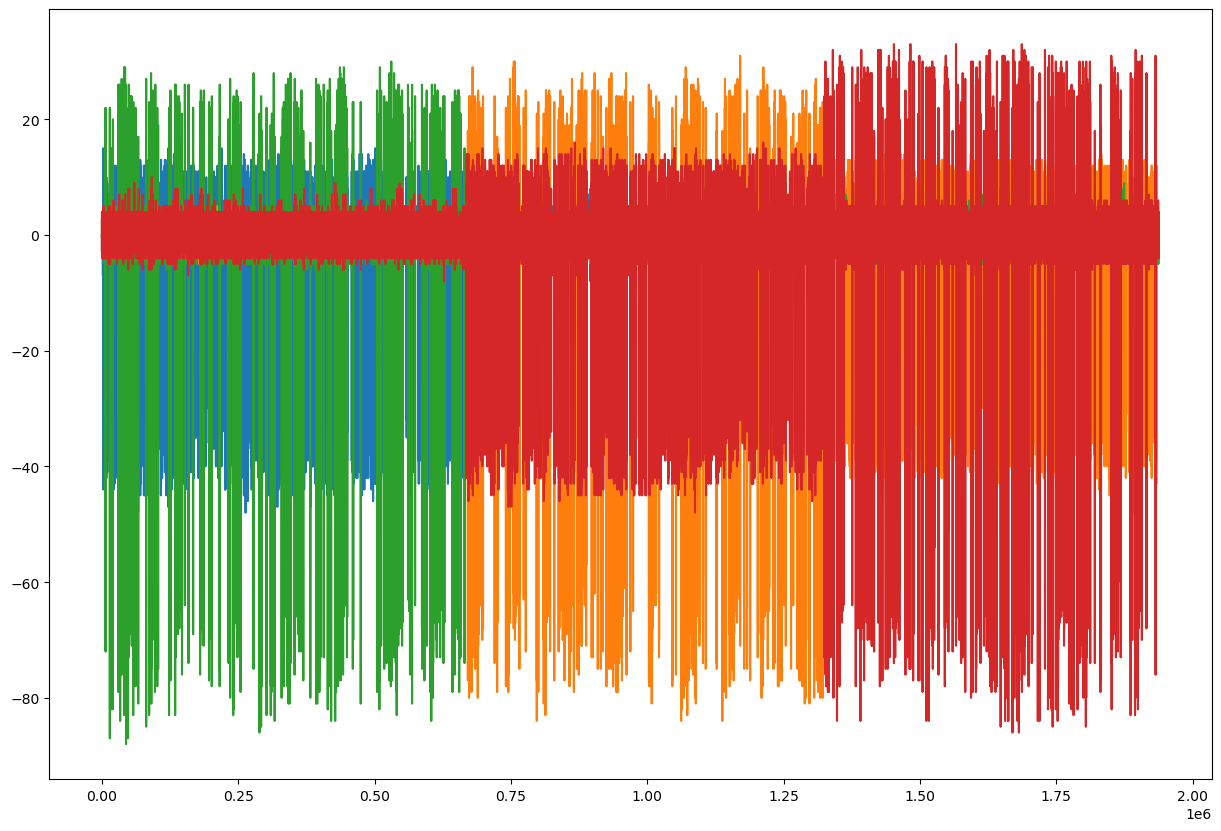

In [516]:
plt.plot(conc_traces)

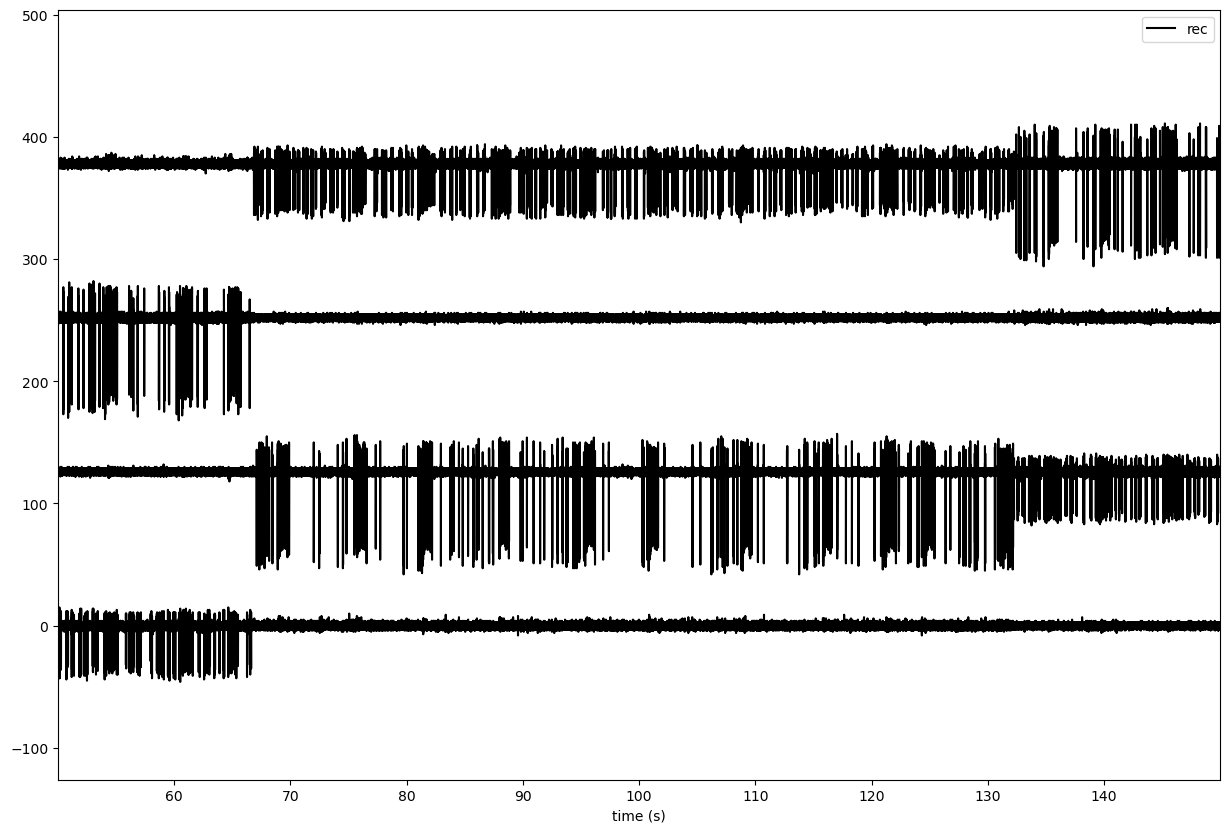

In [501]:
plot_channels = None#[0,1,2,3,4,201,202,203,204,205]
si.plot_timeseries(multirecording, channel_ids = plot_channels, time_range = [50,150])
#plt.ylim([400,600])
plt.show()

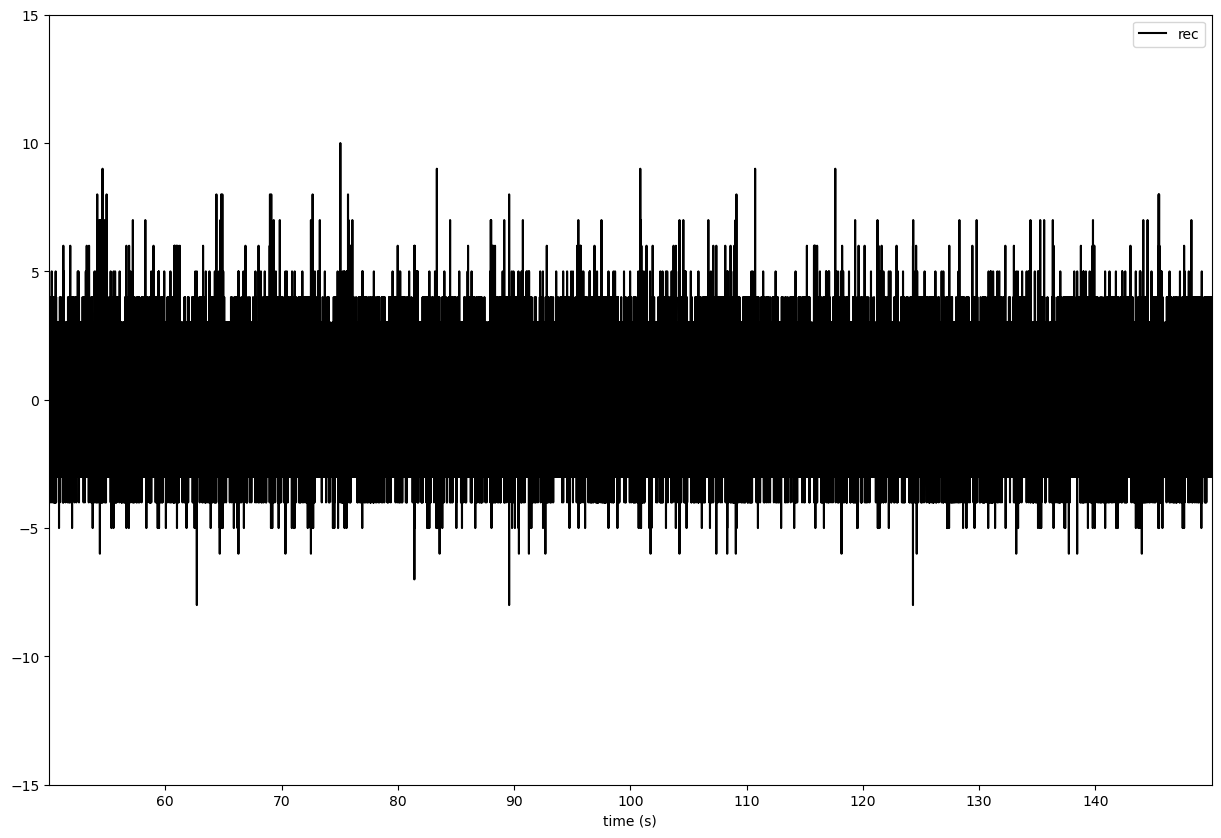

In [397]:
plot_channels = [0]#[0,1,2,3,4,201,202,203,204,205]
si.plot_timeseries(multirecording, channel_ids = plot_channels, time_range = [50,150])
#plt.ylim([400,600])
plt.show()

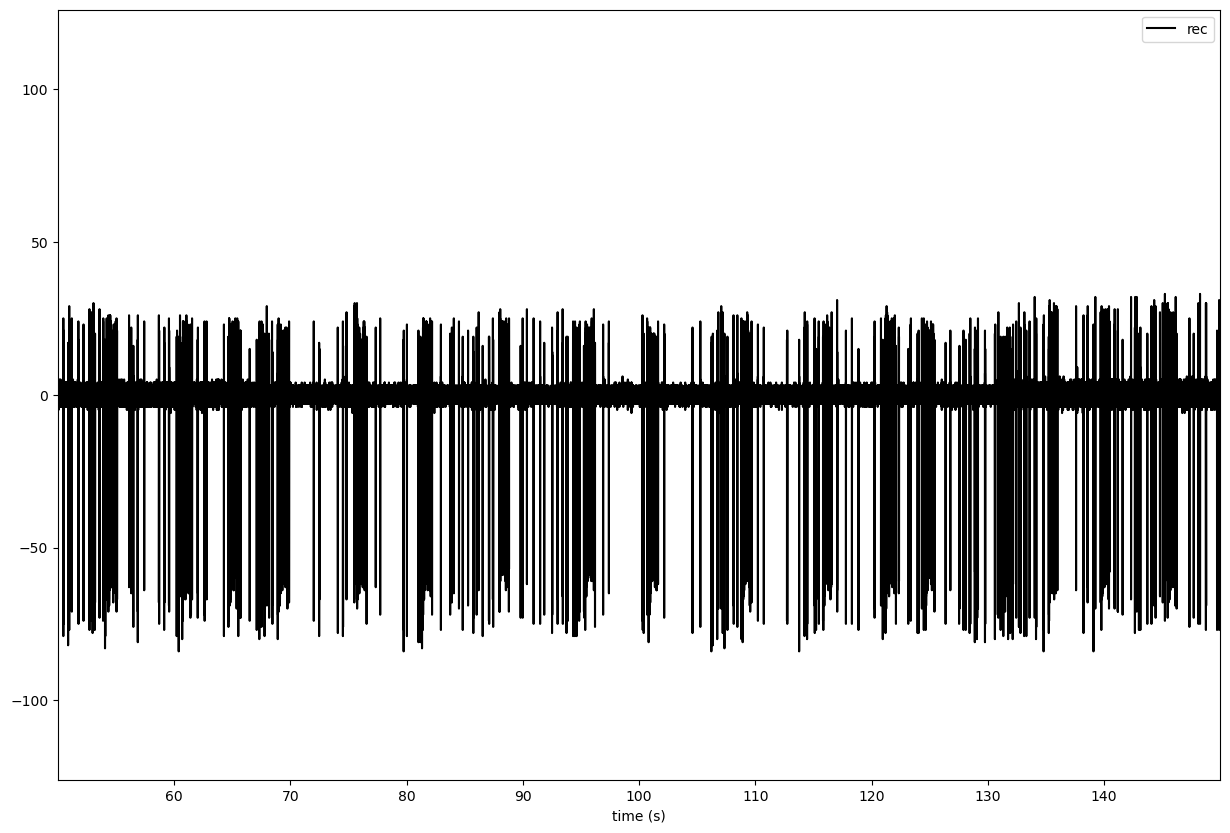

In [398]:
plot_channels = [1]#[0,1,2,3,4,201,202,203,204,205]
si.plot_timeseries(multirecording, channel_ids = plot_channels, time_range = [50,150])
#plt.ylim([400,600])
plt.show()

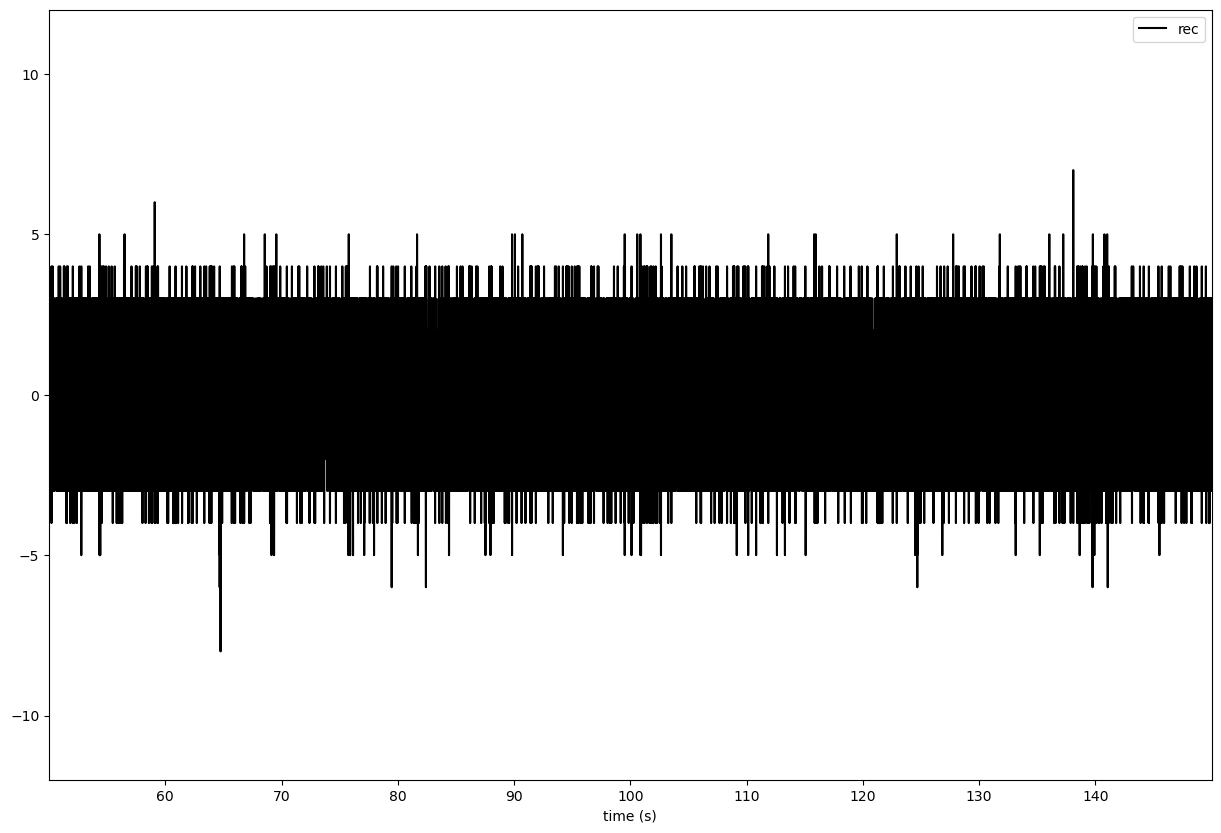

In [399]:
plot_channels = [2]#[0,1,2,3,4,201,202,203,204,205]
si.plot_timeseries(multirecording, channel_ids = plot_channels, time_range = [50,150])
#plt.ylim([400,600])
plt.show()

In [241]:
path_parts = file_path.split('/')
path_parts[0] = '/'
path_parts[6] = 'intermediate_data'
path_parts[8] = 'phornauer'
save_root = os.path.join(*path_parts[0:12])

In [242]:
save_root = save_root + '/zscored'
sorting = clean_sorting(multirecording, save_root, stream_name)

DURATION: 193.78 s -- NUM. CHANNELS: 268


write_binary_recording:   0%|          | 0/194 [00:00<?, ?it/s]

RUNNING SHELL SCRIPT: /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/230427/How_old/M05562/zscored/well001/sorted/sorter_output/run_kilosort2_5.sh


                                                                              < M A T L A B (R) >

                                                                    Copyright 1984-2020 The MathWorks, Inc.

                                                                    R2020b (9.9.0.1467703) 64-bit (glnxa64)

                                                                                August 26, 2020



 

To get started, type doc.

For product information, visit www.mathworks.com.

 

Time   0s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time   3s. Loading raw data and applying filters... 

Time  11s. Finished preprocessing 30 batches. 

Drift correction DISABLED

pitch is 1.750000e+01 um

0.27 sec, 1 batches, 6106 spikes 

5.95 sec, 30 b

In [167]:
rec_list[1].get_total_duration()

65.42

In [10]:
sorting = si.KiloSortSortingExtractor('/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/230427/How_old/M05562/well001/sorted/')

In [9]:
sorting.get_property_keys()

['ContamPct', 'KSLabel', 'KSLabel_repeat', 'Amplitude']

In [243]:
min_n_spikes = 100

ks_label = sorting.get_property('KSLabel')
n_spikes = [len(sorting.get_unit_spike_train(x)) for x in sorting.get_unit_ids()]

mua_idx = ks_label == 'mua'
bad_n_spikes_idx = np.array(n_spikes) < min_n_spikes
bad_idx = mua_idx | bad_n_spikes_idx
bad_id = [i for i, x in enumerate(bad_idx) if x]

cleaned_sorting = sorting.remove_units(bad_id)

print(f'Kept {cleaned_sorting.get_num_units()} out of {sorting.get_num_units()} units')

Kept 19 out of 260 units


In [13]:
wf_folder = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/230427/How_old/M05562/well001/sorted/wf_full/'

In [ ]:
we = si.extract_waveforms(multirecording, clean_sorting, wf_folder,
                          ms_before=1, ms_after=2., max_spikes_per_unit=500,
                          n_jobs=-1, chunk_size=30000, allow_unfiltered=True)

In [317]:
rec_name = 'rec0000'
rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)

In [ ]:
we = si.load_waveforms(wf_folder)

In [15]:
#pc = si.compute_principal_components(we, load_if_exists=True, n_components=3, mode='by_channel_local')
metrics = si.compute_quality_metrics(we, metric_names=['snr', 'isi_violation'], n_jobs=-1)#, 'nearest_neighbor'])

In [16]:
keep_mask = (metrics['snr'] > 7.5) & (metrics['isi_violations_ratio'] < 0.2)
keep_unit_ids = keep_mask[keep_mask].index.values
print(len(keep_unit_ids))

204


In [17]:
curated_sorting = sorting.select_units(keep_unit_ids)
print(curated_sorting)

UnitsSelectionSorting: 204 units - 1 segments - 10.0kHz


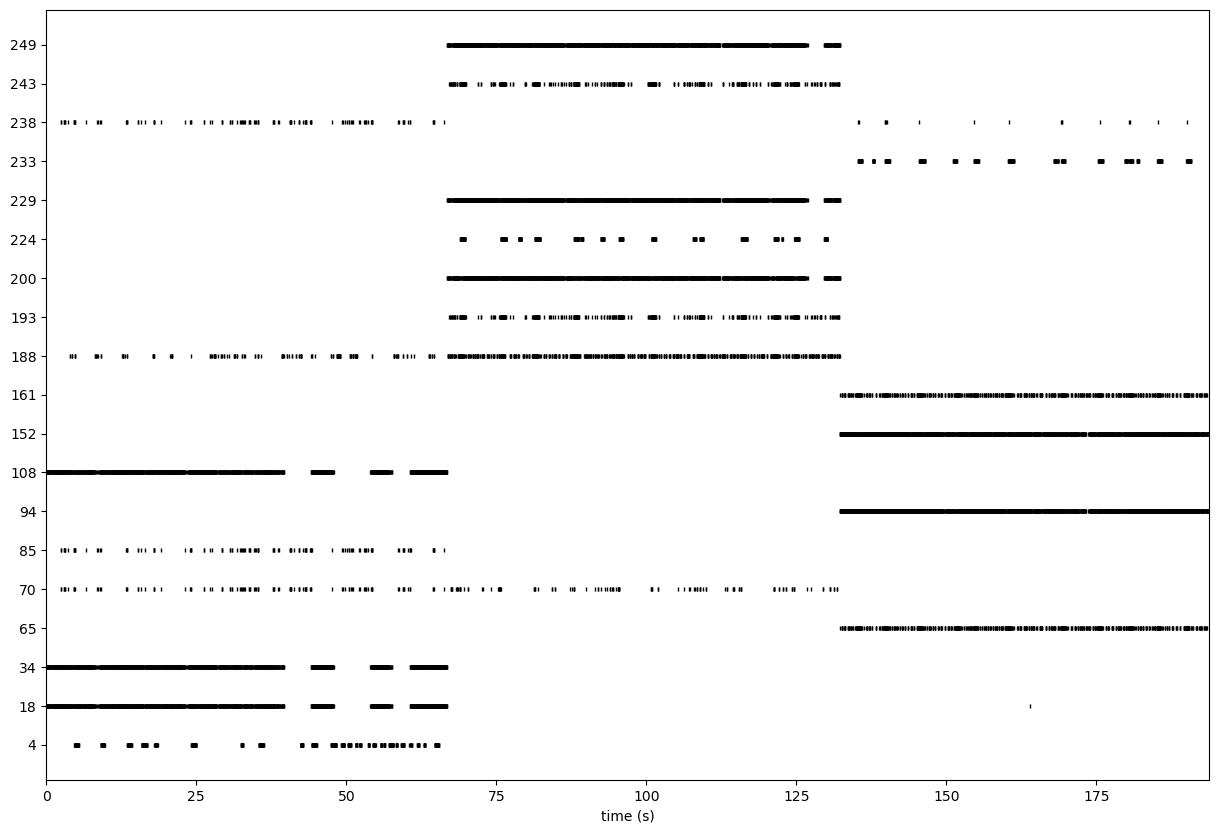

In [244]:
si.plot_rasters(cleaned_sorting, time_range = [0,300])
plt.show()

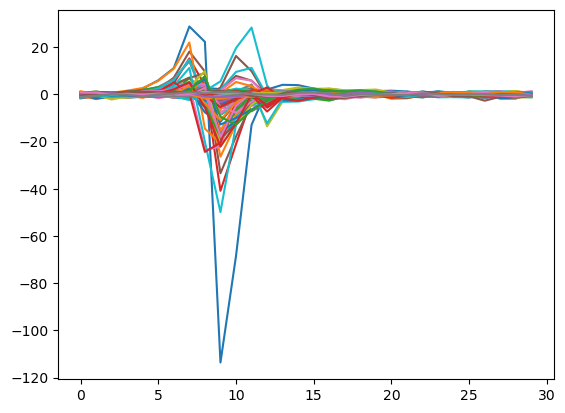

In [18]:
template = we.get_template(keep_unit_ids[3])
template_offset = template - np.median(template,axis=0)
plt.plot(template_offset)
plt.show()

In [19]:
template.shape

(30, 268)

In [114]:
wgt = si.UnitWaveformsWidget(we,unit_ids=[8],plot_waveforms=False,plot_templates=False,plot_channels=True,backend='matplotlib')

In [20]:
split_sorting = si.SplitSegmentSorting(curated_sorting, multirecording)
split_sorting

SplitSegmentSorting: 204 units - 35 segments - 10.0kHz

In [88]:
split_sorting.register_recording(multirecording)

In [145]:
ss = si.SelectSegmentSorting(split_sorting, 34)

In [150]:
we = si.WaveformExtractor.create(rec,ss,#rec_list[0],ss, 
                                 wf_folder + 'seg1', 
                                 allow_unfiltered=True,
                                 remove_if_exists=True)
we.set_params(ms_before=2, ms_after=5)
we.run_extract_waveforms(n_jobs=-1)

extract waveforms memmap:   0%|          | 0/46 [00:00<?, ?it/s]

In [122]:
we

WaveformExtractor: 268 channels - 204 units - 1 segments
  before:30 after:30 n_per_units:500

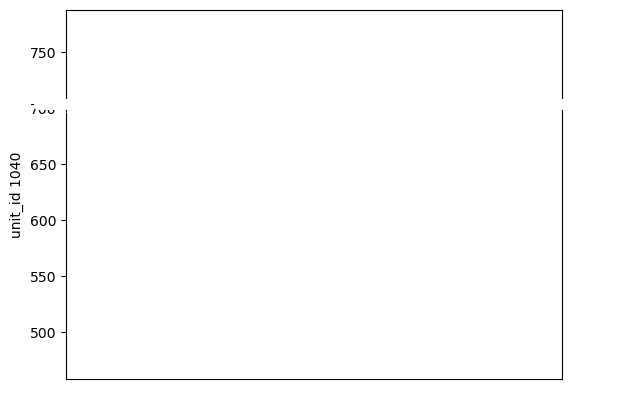

In [156]:
si.plot_unit_waveforms_density_map(waveform_extractor=we,unit_ids=[1040])

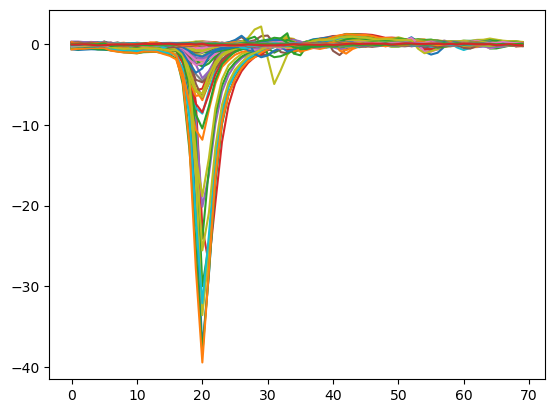

In [151]:
template = we.get_template(1040)
template_offset = template - np.median(template,axis=0)
plt.plot(template_offset)
plt.show()

In [155]:
template.shape

(70, 884)

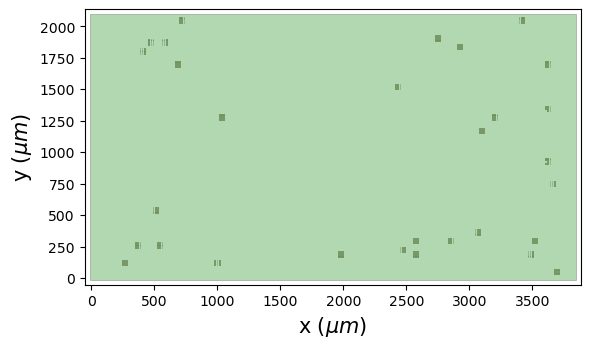

In [138]:
si.plot_probe_map(multirecording)